# Titanic

Following the Keggle kernel https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook

## Configure environment

In [1]:
'''
Load Packages
'''

import sys # access to system parameters
print('Python version: {}'.format(sys.version))

import pandas as pd # library of functions for data processing
print('pandas version: {}'.format(pd.__version__))

import matplotlib # functions for visualization
print('matplotlib version: {}'.format(matplotlib.__version__))

import numpy as np # package for scientific computing
print('NumPy version: {}'.format(np.__version__))

import scipy as sp # functions for scientific computing and advanced mathematics
print('SciPy version: {}'.format(sp.__version__))

import IPython.display
from IPython import display # printing fancy in Jupyter notebook
print('IPython version: {}'.format(IPython.__version__))

import sklearn # collection of machine learning algorithms
print('scikit-learn version: {}'.format(sklearn.__version__))

import random
import time

import warnings
warnings.filterwarnings('ignore')
#print('-'*25)

# Input datafiles
#from subprocess import check_output
#print(check_output(['ls','/data']).decode('utf8'))

Python version: 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.22.0
matplotlib version: 2.1.0
NumPy version: 1.14.0
SciPy version: 1.0.0
IPython version: 6.2.1
scikit-learn version: 0.19.1


In [2]:
'''
Load data modelling libraries
'''
# Model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier # only works on osx and linux

# Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure visualization defaults
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Load and investigate data

In [3]:
'''
First look at the data
'''

# data for training and testing
data_raw = pd.read_csv('data/train.csv') 

# final validation set for competition submission
data_val = pd.read_csv('data/test.csv') 

# create a copy of the data to use
data1 = data_raw.copy(deep=True)

# reference for convenience. Helpful for cleaning operations
data_cleaner = [data1, data_val]

print(data_raw.info())
print(data_val.info())
#data_raw.head()
#data_raw.tail()
#data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

In [4]:
print('Train columns with null values:\n', data1.isnull().sum())
print('-'*25)

print('Validation columns with null values:\n', data_val.isnull().sum())
print('-'*25)

data_raw.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
-------------------------
Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
-------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hanna, Mr. Mansour",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## Data cleaning: Correcting, Completing, Creating and Converting

In [5]:
# No need for correction (no misstakes or extreme outliers)

# Completing
for dataset in data_cleaner: # apply to both training and validation set
    # complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(),inplace=True)
    
    # complete embark with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace=True)
    
    # complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(),inplace=True)
    
# delete the features to exclude in training dataset
drop_column = ['PassengerId','Cabin','Ticket']
data1.drop(drop_column,axis=1,inplace=True)


In [6]:
# Have we completed?
print(data1.isnull().sum())
print('-'*25)
print(data_val.isnull().sum())
# Yes

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
-------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [7]:
# Create: feature engineering from train and validation dataset
for dataset in data_cleaner:
    # Discrete variables
    
    # Size of families
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    # Travelin alone
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize']>1] = 0
    
    # Extract title from name
    dataset['Title'] = dataset['Name'].str.split(", ",expand=True)[1].str.split(".",expand=True)[0]
    
    # Continous variables
    
    # Bin Fares in quantiles
    dataset['FareBin'] = pd.qcut(dataset['Fare'],4)
    
    # Bin Ages in bins of equal width
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int),5)
    
# clean rare title names
stat_min = 10
title_names_data1 = (data1['Title'].value_counts() < stat_min)
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names_data1.loc[x] == True else x)

title_names_data_val = (data_val['Title'].value_counts() < stat_min)
data_val['Title'] = data_val['Title'].apply(lambda x: 'Misc' if title_names_data_val.loc[x] == True else x)

# Preview data
#print(data1['Title'].value_counts())
#print(data_val['Title'].value_counts())
#data1.info()
#data_val.info()

In [8]:
# Converting formats: Dummy variables for mathematical analysis using Label Encoder

# Code categorical data

for dataset in data_cleaner:
    dataset['Sex_code'] = LabelEncoder().fit_transform(dataset['Sex'])
    dataset['Embarked_code'] = LabelEncoder().fit_transform(dataset['Embarked'])
    dataset['Title_code'] = LabelEncoder().fit_transform(dataset['Title'])
    dataset['AgeBin_code'] = LabelEncoder().fit_transform(dataset['AgeBin'])
    dataset['FareBin_code'] = LabelEncoder().fit_transform(dataset['FareBin'])

# define yvariable aka Target/outcome 
Target = ['Survived']

data1_x = [
    'Sex','Pclass', 'Embarked', 
    'Title', 'SibSp', 'Parch', 
    'Age', 'Fare', 'FamilySize', 
    'IsAlone'
]

data1_x_calc = [
    'Sex_code','Pclass', 'Embarked_code', 
    'Title_code', 'SibSp', 'Parch', 
    'Age', 'Fare', 'FamilySize', 
    'IsAlone'
]

data1_x_bin = [
    'Sex_code','Pclass', 'Embarked_code', 
    'Title_code', 'FamilySize', 'AgeBin_code',
    'FareBin_code'
]

data1_xy = Target + data1_x
data1_xy_bin = Target + data1_x_bin

print('Original X Y: ', data1_xy, '\n')
print('Bin X Y: ', data1_xy_bin, '\n')

# Define x and y variables for dummy feature original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy

print('Dummy X Y: ', data1_xy_dummy, '\n')

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_code', 'Pclass', 'Embarked_code', 'Title_code', 'FamilySize', 'AgeBin_code', 'FareBin_code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



In [9]:
print('Train columns with null values: \n', data1.isnull().sum())
print('-'*25)
print(data1.info())
print('-'*25)

print('Validation columns with null values: \n', data_val.isnull().sum())
print('-'*25)
print(data_val.info())
print('-'*25)

data_raw.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_code         0
Embarked_code    0
Title_code       0
AgeBin_code      0
FareBin_code     0
dtype: int64
-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hanna, Mr. Mansour",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# Split training and testing data

In [10]:
# split train and test data with function defaults

train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(
    data1[data1_x_calc],
    data1[Target],
    random_state = 0
)

train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(
    data1[data1_x_bin], 
    data1[Target],
    random_state = 0
)

train1_x_dummy, test1_x_dummy, train_y_dummy, test1_y_dummy = model_selection.train_test_split(
    data1_dummy[data1_x_dummy],
    data1[Target],
    random_state = 0
)


print('Data1 Shape: {}'.format(data1.shape))
print('Train1 Shape: {}'.format(train1_x.shape))
print('Test1 Shape: {}'.format(test1_x.shape))


train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 10)
Test1 Shape: (223, 10)


,Sex_code,Pclass,Embarked_code,Title_code,FamilySize,AgeBin_code,FareBin_code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


## Exploratory analusis with statistics

In [11]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null category
AgeBin           891 non-null category
Sex_code         891 non-null int64
Embarked_code    891 non-null int64
Title_code       891 non-null int64
AgeBin_code      891 non-null int64
FareBin_code     891 non-null int64
dtypes: category(2), float64(2), int64(11), object(4)
memory usage: 120.3+ KB


In [12]:
for x in data1_x :
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:',x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*25,'\n')

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
------------------------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
------------------------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
------------------------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
------------------------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
------------------------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
------------------------

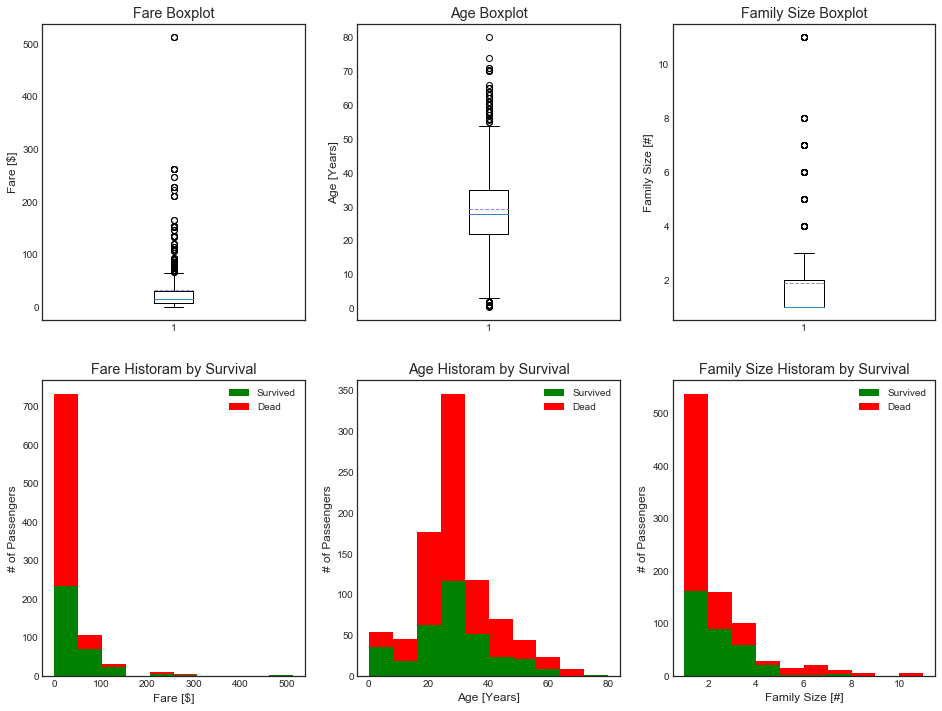

In [13]:
# plotting continous variables

plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x = data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare [$]')

plt.subplot(232)
plt.boxplot(x = data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age [Years]')

plt.subplot(233)
plt.boxplot(x = data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size [#]')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'],data1[data1['Survived']==0]['Fare']],
         stacked = True, color = ['g','r'], label = ['Survived','Dead'])
plt.title('Fare Historam by Survival')
plt.xlabel('Fare [$]')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'],data1[data1['Survived']==0]['Age']],
         stacked = True, color = ['g','r'], label = ['Survived','Dead'])
plt.title('Age Historam by Survival')
plt.xlabel('Age [Years]')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'],data1[data1['Survived']==0]['FamilySize']],
         stacked = True, color = ['g','r'], label = ['Survived','Dead'])
plt.title('Family Size Historam by Survival')
plt.xlabel('Family Size [#]')
plt.ylabel('# of Passengers')
plt.legend()

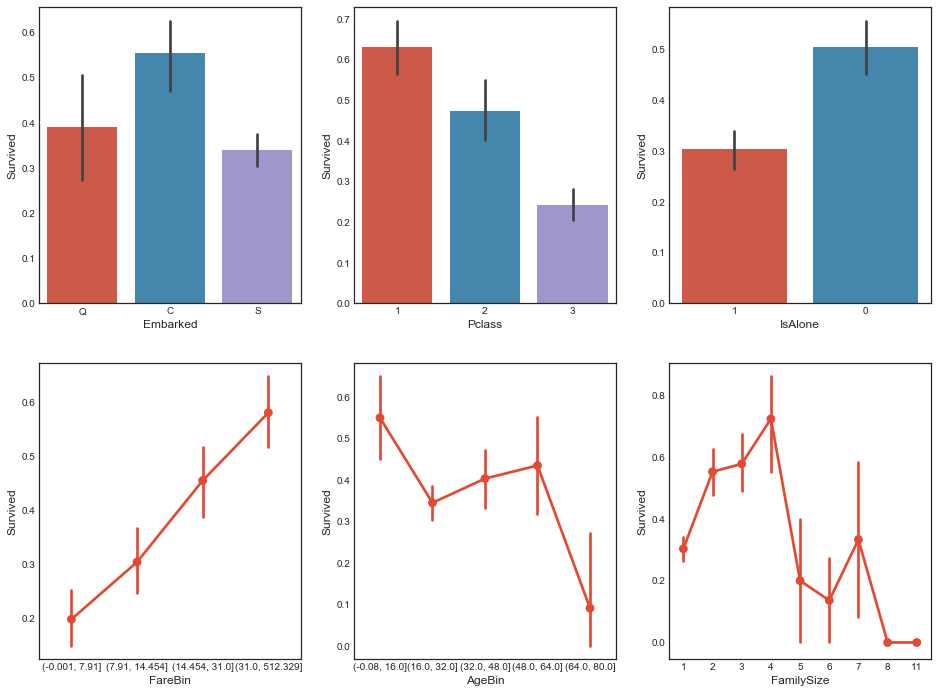

In [14]:
fig, saxis = plt.subplots(2,3,figsize=(16,12))

sns.barplot(x= 'Embarked', y = 'Survived', order = ['Q','C','S'], data=data1, ax = saxis[0,0])
sns.barplot(x= 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
sns.barplot(x= 'IsAlone', y = 'Survived', order = [1,0], data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived', data = data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived', data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

Text(0.5,1,'Pclass vs Family Size Survival Comparison')

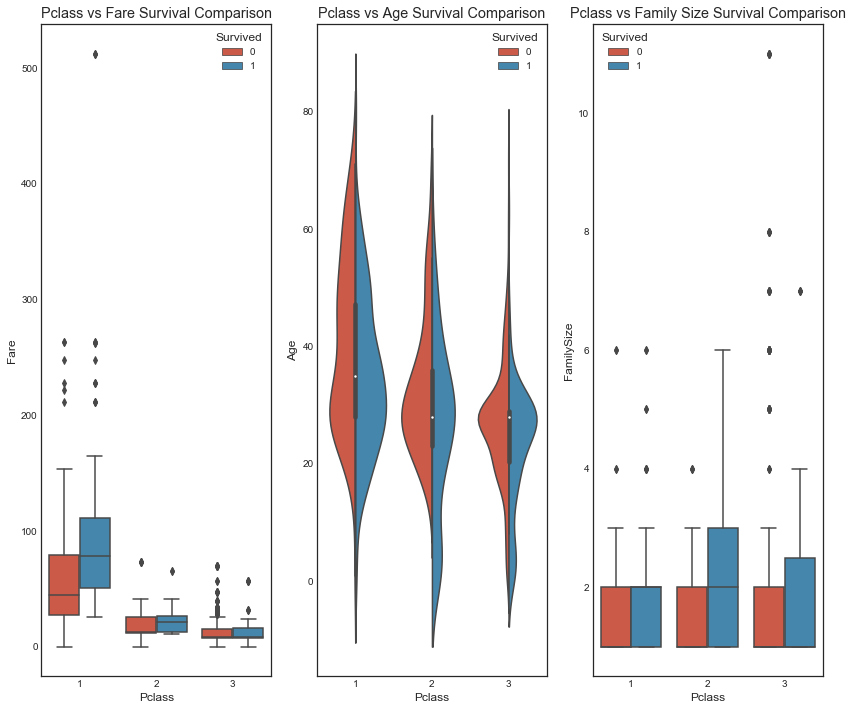

In [15]:
# Graph qualitative data

fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y = 'FamilySize', hue = 'Survived', data = data1, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

In [16]:
data1['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

Text(0.5,1,'Sex vs IsAlone Survival Comparison')

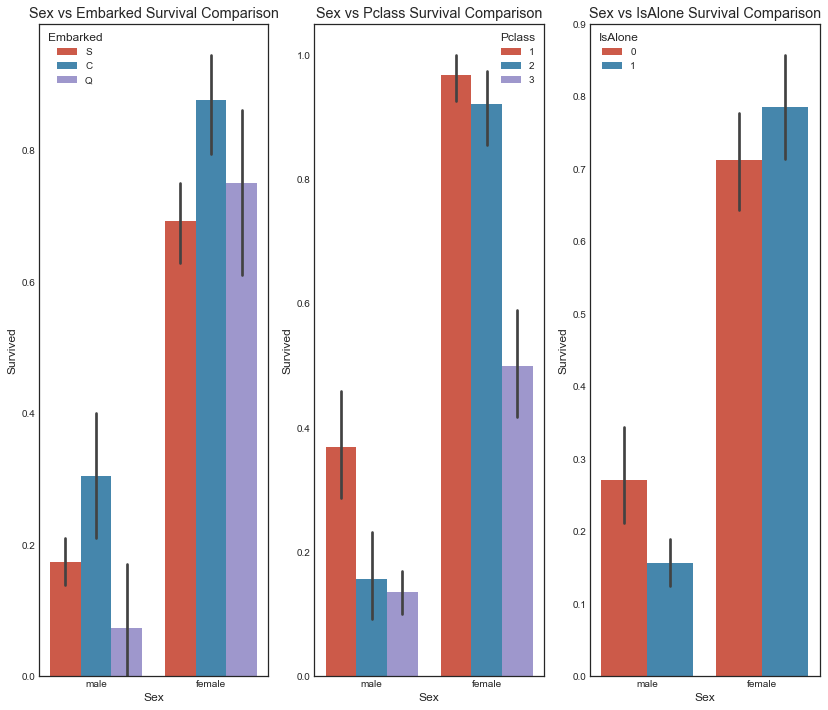

In [17]:
# distribution of qualitative data: sex

fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax = qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax = qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survival Comparison')

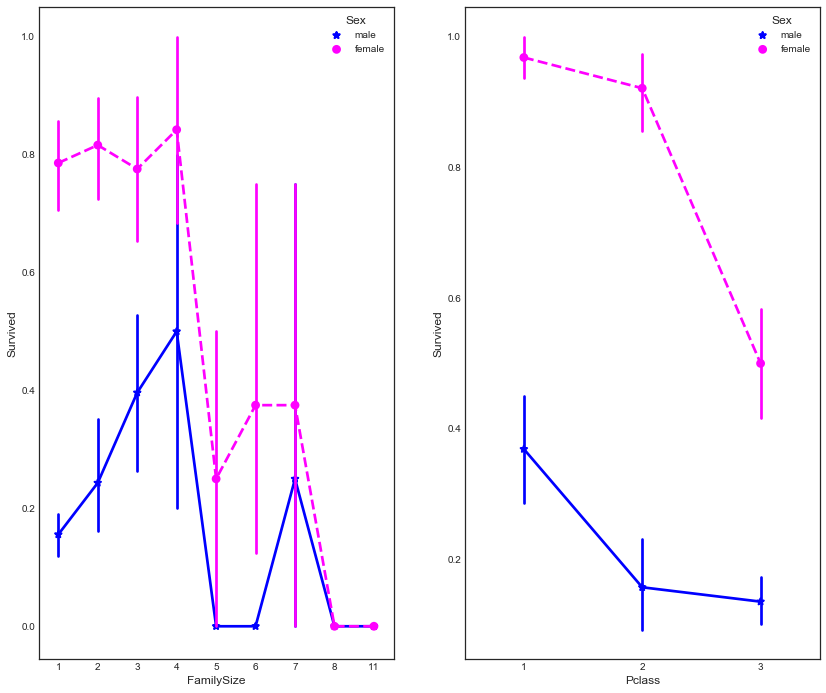

In [18]:
# more comparisons

fig, (maxis1,maxis2) = plt.subplots(1,2,figsize=(14,12))

sns.pointplot(x='FamilySize', y = 'Survived', hue='Sex', data=data1,
             palette = {'male':'blue', 'female':'magenta'},
             markers=['*','o'], linestyles=['-','--'], ax = maxis1)

sns.pointplot(x='Pclass', y = 'Survived', hue='Sex', data=data1,
             palette = {'male':'blue', 'female':'magenta'},
             markers=['*','o'], linestyles=['-','--'], ax = maxis2)

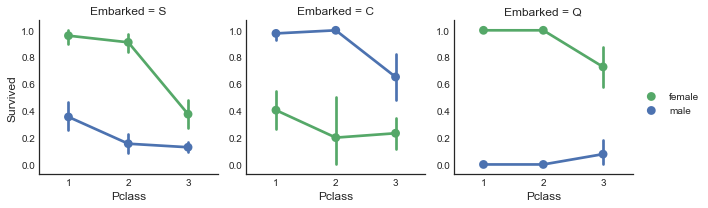

In [19]:
# Embark port factor with class, sex and survivla rate
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci =95.0, palette = 'deep')
e.add_legend()

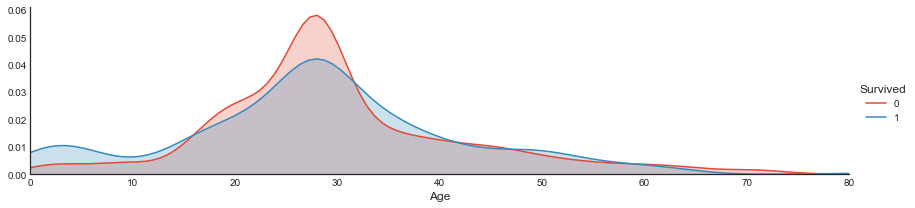

In [20]:
# Age distribution of passengers who survived and died
a = sns.FacetGrid(data1, hue = 'Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade='True')
a.set(xlim=(0,data1['Age'].max()))
a.add_legend()

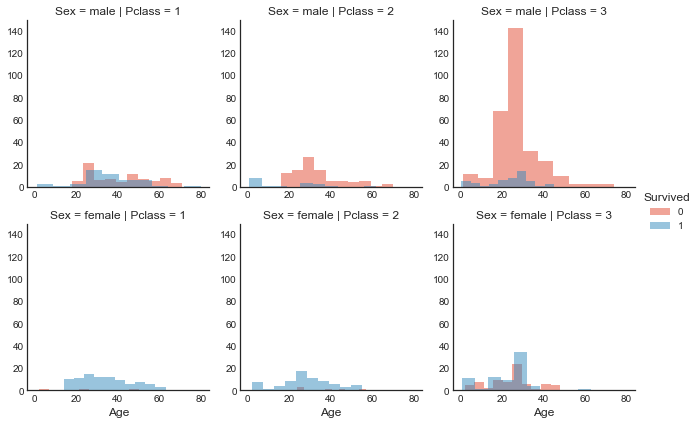

In [21]:
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist,'Age', alpha=.5)
h.add_legend()

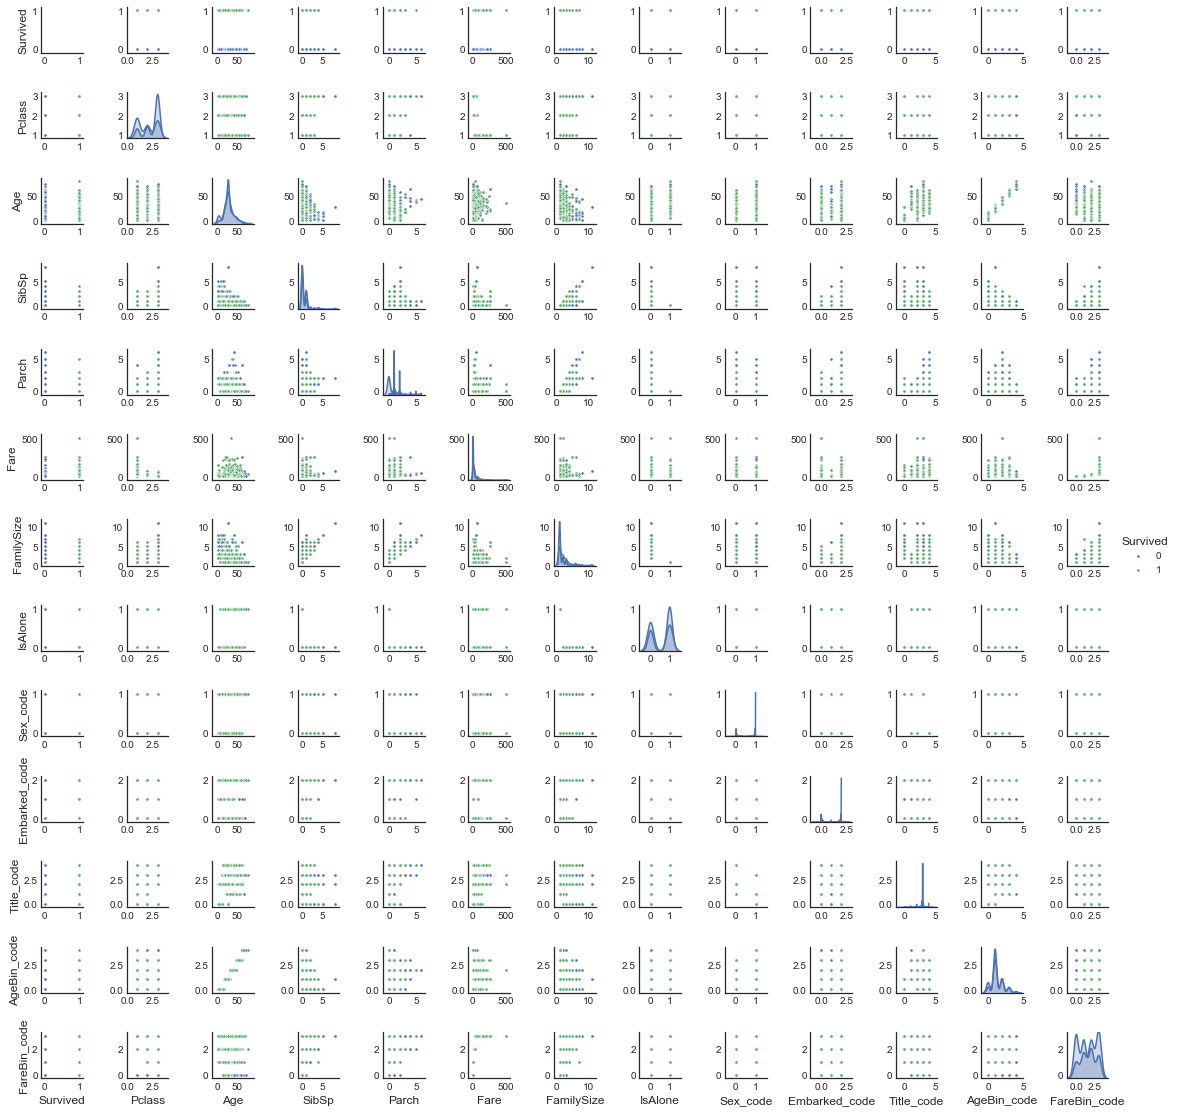

In [22]:
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde',
                  diag_kws=dict(shade=True), plot_kws=dict(s=10))

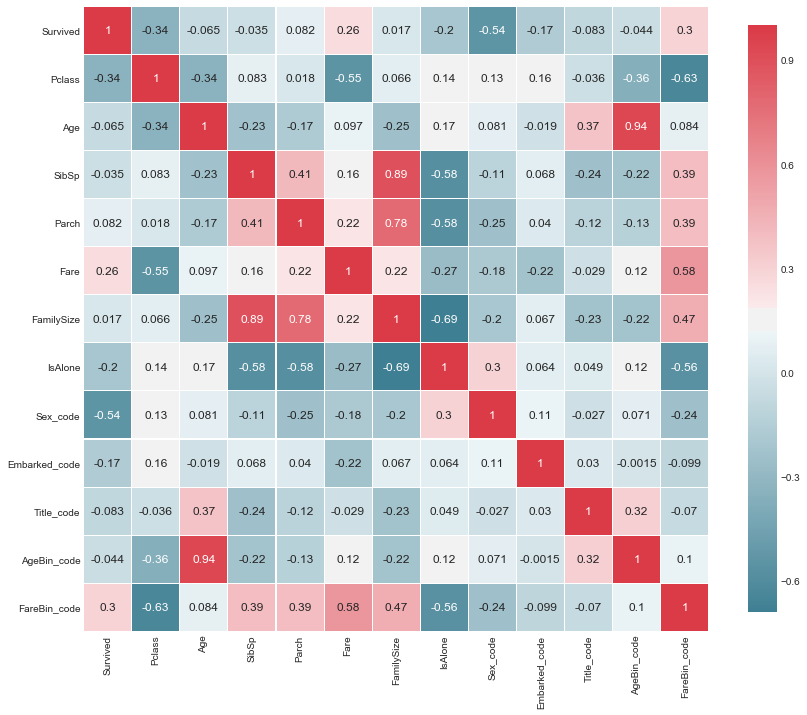

In [23]:
# correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize=(14,12))
    colormap = sns.diverging_palette(220,10,as_cmap=True)
    
    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square = True,
        cbar_kws = {'shrink':.9},
        ax = ax,
        annot = True,
        linewidths = 0.1, vmax = 1.0, linecolor = 'white',
        annot_kws = {'fontsize':12}
    )
    
correlation_heatmap(data1)

# Model data

In [25]:
# Machine learning algorithms (MLA) selection and initialization
MLA = [
    # Ensemble methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # Gaussian processes
    gaussian_process.GaussianProcessClassifier(),
    
    # Generalized Learning Models
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # Support Vector Machines
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # xgboost
    #XGBClassifier()
]

# Split dataset into cross validation sets
cv_split = model_selection.ShuffleSplit(n_splits = 10,
                                        test_size =0.3,
                                        train_size=0.6,
                                        random_state=0                                    
                                       )
# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean',
              'MLA Test Accuracy Mean', 'MLA Train Accuracy 3*STD',
               'MLA Test Accuracy 3*STD', 'MLA Time'
              ]
MLA_compare = pd.DataFrame(columns = MLA_columns)

# create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # score model with cross validation
    cv_results = model_selection.cross_validate(alg, 
                                                data1[data1_x_bin], 
                                                data1[Target], 
                                                cv = cv_split
                                               )
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy 3*STD'] = cv_results['train_score'].std()*3
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1
    
#print and sort table
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
#MLA_compare

Text(0,0.5,'Algorithm')

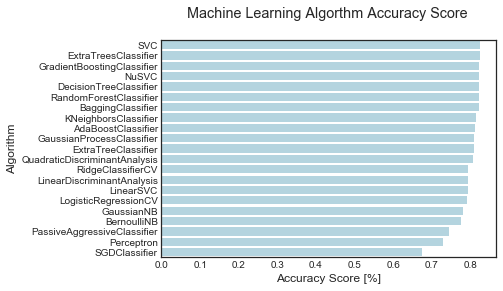

In [26]:
# barplot
sns.barplot(x = 'MLA Test Accuracy Mean', 
            y = 'MLA Name', 
            data = MLA_compare, 
            color ='lightblue'
           )
plt.title('Machine Learning Algorthm Accuracy Score \n')
plt.xlabel('Accuracy Score [%]')
plt.ylabel('Algorithm')

### Which are similar to each other?

In [ ]:
correlation_heatmap(MLA_predict)

From these results we can see that there are several machine learning algorithms that perform almost equally well. Let us procede with:
 * SVC
 * BaggingClassifier
 * GradientBoostingClassifier
 * RandomForestClassifier 

In [ ]:
# Some more metrics
alg = svm.SVC(probability=True)
alg.fit(data1[data1_x_bin], data1[Target])
print('SVC Model Accuracy/Precision Score:')
print(metrics.classification_report(data1['Survived'], alg.predict(data1[data1_x_bin])))

In [ ]:
print('Confusion matrix: \n[[TN FP]\n [FN TP]]\n')
print(metrics.confusion_matrix(data1['Survived'], alg.predict(data1[data1_x_bin])))

# Tune model

### conducting hyper parameter optimization

In [ ]:
# Tune SVC classifier
alg1 = svm.SVC(probability=True)
base_results = model_selection.cross_validate(alg1, 
                                                             data1[data1_x_bin], 
                                                             data1[Target],
                                                            cv = cv_split)
alg1.fit(data1[data1_x_bin],data1[Target])

print('Original SVC Parameters: ', alg1.get_params())
print('Original SVC Training w/bin score mean {:.2f}%'.format(base_results['train_score'].mean()*100))
print('Original SVC Test w/bin score mean {:.2f}%'.format(base_results['test_score'].mean()*100))
print('Original SVC Test w/bin 3*STD {:.2f}%'.format(base_results['train_score'].std()*100*3))

print('-'*25)

# tune hyper parameters
param_grid = {
    'C': [0.01,0.1,1.0,10], # Penalty parameter of error term
    #'decision_function_shape': ['ovr','ovo'], 
    'kernel': ['rbf','linear','poly','sigmoid'], 
    #'random_state': [0,10,100]
}

tune_model = model_selection.GridSearchCV(alg1,
                                          param_grid = param_grid,
                                          scoring = 'roc_auc',
                                          cv = cv_split,
                                         )
tune_model.fit(data1[data1_x_bin], data1[Target])

print('Optimized SVC Parameters: ', tune_model.best_params_)
print('Optimized SVC Training w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print('Optimized SVC Test w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('Optimized SVC Test w/bin score 3*STD: {:.2f}'.format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100))

print('-'*25)


In [ ]:
# Tune BaggingClassifier classifier
alg2 = ensemble.BaggingClassifier()
base_results = model_selection.cross_validate(alg2, 
                                                             data1[data1_x_bin], 
                                                             data1[Target],
                                                            cv = cv_split)
alg2.fit(data1[data1_x_bin],data1[Target])

print('Original Bagging Parameters: ', alg2.get_params())
print('Original Bagging Training w/bin score mean {:.2f}%'.format(base_results['train_score'].mean()*100))
print('Original Bagging Test w/bin score mean {:.2f}%'.format(base_results['test_score'].mean()*100))
print('Original Bagging Test w/bin 3*STD {:.2f}%'.format(base_results['train_score'].std()*100*3))

print('-'*25)

# tune hyper parameters
param_grid = {
    'n_estimators': [5,10,15,20,30,40,50,60,70,80,90,100], 
    'random_state': [0], 
}

tune_model = model_selection.GridSearchCV(alg2,
                                          param_grid = param_grid,
                                          scoring = 'roc_auc',
                                          cv = cv_split,
                                         )
tune_model.fit(data1[data1_x_bin], data1[Target])

print('Optimized Bagging Parameters: ', tune_model.best_params_)
print('Optimized Bagging Training w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print('Optimized Bagging Test w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('Optimized Bagging Test w/bin score 3*STD: {:.2f}'.format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100))

print('-'*25)


In [ ]:
# Tune BaggingClassifier classifier
alg3 = ensemble.GradientBoostingClassifier()
base_results = model_selection.cross_validate(alg3, 
                                                             data1[data1_x_bin], 
                                                             data1[Target],
                                                            cv = cv_split)
alg3.fit(data1[data1_x_bin],data1[Target])

print('Original GBC Parameters: ', alg3.get_params())
print('Original GBC Training w/bin score mean {:.2f}%'.format(base_results['train_score'].mean()*100))
print('Original GBC Test w/bin score mean {:.2f}%'.format(base_results['test_score'].mean()*100))
print('Original GBC Test w/bin 3*STD {:.2f}%'.format(base_results['train_score'].std()*100*3))

print('-'*25)

# tune hyper parameters
param_grid = {#'criterion': 'friedman_mse', 
              #'init': None, 
              #'learning_rate': 0.1, 
              'loss': ['deviance','exponential'], 
              'max_depth': [2,3,4,5,6], 
              #'max_features': None, 
              #'max_leaf_nodes': None, 
              #'min_impurity_decrease': 0.0, 
              #'min_impurity_split': None, 
              #'min_samples_leaf': [1,2,3], 
              #'min_samples_split': [1.0,2,3], 
              #'min_weight_fraction_leaf': 0.0, 
              'n_estimators': [10,50,100,200,300], 
              #'presort': 'auto', 
              'random_state': [0], 
              #'subsample': [0.5,1.0,2.0], 
              #'verbose': 0, 
              #'warm_start': False
             }

tune_model = model_selection.GridSearchCV(alg3,
                                          param_grid = param_grid,
                                          scoring = 'roc_auc',
                                          cv = cv_split,
                                         )
tune_model.fit(data1[data1_x_bin], data1[Target])

print('Optimized GBC Parameters: ', tune_model.best_params_)
print('Optimized GBC Training w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print('Optimized GBC Test w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('Optimized GBC Test w/bin score 3*STD: {:.2f}'.format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100))

print('-'*25)


In [ ]:
# Tune BaggingClassifier classifier
alg4 = ensemble.RandomForestClassifier()
base_results = model_selection.cross_validate(alg4, 
                                                             data1[data1_x_bin], 
                                                             data1[Target],
                                                            cv = cv_split)
alg4.fit(data1[data1_x_bin],data1[Target])

print('Original Random Forest Parameters: ', alg4.get_params())
print('Original Random Forest Training w/bin score mean {:.2f}%'.format(base_results['train_score'].mean()*100))
print('Original Random Forest Test w/bin score mean {:.2f}%'.format(base_results['test_score'].mean()*100))
print('Original Random Forest Test w/bin 3*STD {:.2f}%'.format(base_results['train_score'].std()*100*3))

print('-'*25)

# tune hyper parameters
param_grid = {#'bootstrap': True, 
              #'class_weight': None, 
              #'criterion': ['gini','entropy'], 
              #'max_depth': [None,3,5,7,9,11], 
              #'max_features': 'auto', 
              #'max_leaf_nodes': None, 
              #'min_impurity_decrease': 0.0, 
              #'min_impurity_split': None, 
              'min_samples_leaf': [1,2,3,4,5,7], 
              #'min_samples_split': 2, 
              #'min_weight_fraction_leaf': 0.0, 
              'n_estimators': [5,6,7,8,9,10,11,12,20,30,50,70,100], 
              #'n_jobs': [1,3,5], 
              #'oob_score': False, 
              'random_state': [0], 
              #'verbose': 0, 
              #'warm_start': False
             }

tune_model = model_selection.GridSearchCV(alg4,
                                          param_grid = param_grid,
                                          scoring = 'roc_auc',
                                          cv = cv_split,
                                         )
tune_model.fit(data1[data1_x_bin], data1[Target])

print('Optimized Random Forest Parameters: ', tune_model.best_params_)
print('Optimized Random Forest Training w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print('Optimized Random Forest Test w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('Optimized Random Forest Test w/bin score 3*STD: {:.2f}'.format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100))

print('-'*25)


In [ ]:
data_val.head()

In [ ]:
alg = ensemble.GradientBoostingClassifier(max_depth=2, n_estimators=200, random_state = 0)
alg.fit(data1[data1_x_bin],data1[Target])
data_val['Survived'] = alg.predict(data_val[data1_x_bin])

In [ ]:
data_val.head()

In [ ]:
submit = data_val[['PassengerId','Survived']]
submit.to_csv('submission/submit.csv', index=False)

#print('Validation Data Distribution: \n', data_val['Survived'].value_counts(normalize = True))
submit.sample(10)